# Notebook de treinamento visual transformers com os dados classificados por especialistas com aumentação de dados

Neste notebook treinamos visual transformers partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação. Utilizamos aumentação de dados.

# Base de dados e importações

In [ ]:
!gdown --id 1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V --output audio_wav_especialistas.zip
!unzip audio_wav_especialistas.zip
!rm -rf audio_wav_especialistas.zip  
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V
To: /content/audio_wav_especialistas.zip
607MB [00:06, 87.2MB/s]
Archive:  audio_wav_especialistas.zip
   creating: content/audios_expecialistas/
  inflating: content/audios_expecialistas/30fa4631-eba2-44d7-ba44-4ef930092d45.wav  
  inflating: content/audios_expecialistas/9b110ff2-f5c2-4e6e-8bb3-31f502375c7d.wav  
  inflating: content/audios_expecialistas/0b6f8543-c5e3-414c-a4f3-020e56e8ec60.wav  
  inflating: content/audios_expecialistas/c3174535-aaef-4c26-b0b5-a38996e54763.wav  
  inflating: content/audios_expecialistas/46723cf9-49fd-404f-b62f-6ba97019d921.wav  
  inflating: content/audios_expecialistas/2e0e732f-3cf5-4fb6-9762-aae4ab603d4d.wav  
  inflating: content/audios_expecialistas/8debc554-dee0-49c8-8a54-34c26de4190d.wav  
  inflating: content/audios_expecialistas/98e4742a-3aab-4dcb-a5b8-e903f91c4324.wav  
  inflating: content/audios_expecialistas/20638b85-0ab9-45cc-b257-9ce9986946de.wav  
  i

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import concurrent.futures
import multiprocessing
import time
import gc
import cv2
import librosa

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.wav'
val['uuid'] = val['uuid'] + '.wav'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

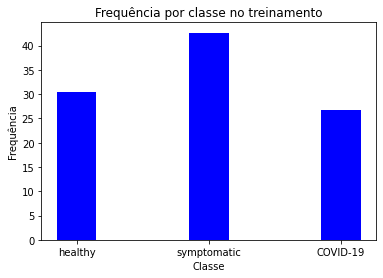

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

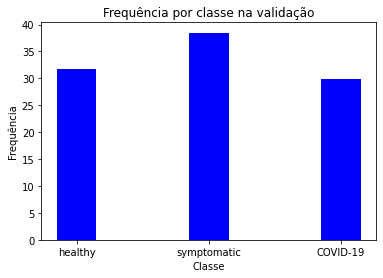

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

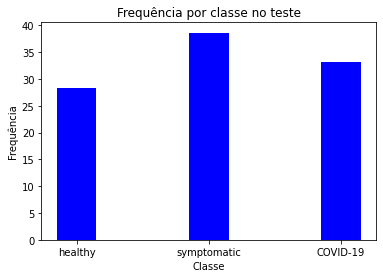

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

In [ ]:
lista_audios_train = []
label_audios_train = []

for i in train.values:
  lista_audios_train.append('/content/content/audios_expecialistas/' + i[1])
  label_audios_train.append(i[-2])

In [ ]:
lista_audios_val = []
label_audios_val = []

for i in val.values:
  lista_audios_val.append('/content/content/audios_expecialistas/' + i[1])
  label_audios_val.append(i[-2])

In [ ]:
#métodos como base https://www.kaggle.com/huseinzol05/sound-augmentation-librosa
DEBUG_MODE = False
SAMPLE_RATE = 22050

def add_noise(y):
  if (DEBUG_MODE):
    print('add_noise')
  y_noise = y.copy()
  noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
  y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
  return y_noise

def add_white_noise(y):
  if (DEBUG_MODE):
    print('add_white_noise')
  wn = np.random.randn(len(y))
  data_wn = y + 0.020*wn
  return wn

def add_harmonic(y):
  if (DEBUG_MODE):
    print('add_harmonic')
  y_harmonic, y_percussive = librosa.effects.hpss(y.astype('float64'))
  return y_harmonic

def add_streching(y):
  if (DEBUG_MODE):
    print('add_streching')
  input_length = len(y)
  streching = y.copy()
  streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
  if len(streching) > input_length:
    streching = streching[:input_length]
  else:
    streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
  return streching

def change_speed(y):
  if (DEBUG_MODE):
    print('change_speed')
  y_speed = y.copy()
  speed_change = np.random.uniform(low=0.1,high=3)
  tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
  minlen = min(y_speed.shape[0], tmp.shape[0])
  y_speed *= 0 
  y_speed[0:minlen] = tmp[0:minlen]
  return y_speed

def add_pitch(y, sample_rate= SAMPLE_RATE):
  if (DEBUG_MODE):
    print('add_pitch')
  y_pitch = y.copy()
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
  return y_pitch

def nothing(y):
  return y

In [ ]:
def apply_data_augmentation(audio_time_series, conj):
    if conj == 1:
      operation = ['nothing', 'harmonic', 'streching', 'pitch']
    else:
      operation = ['nothing']
    op = np.random.choice(operation)
    sr = 22050
    signal, _ = librosa.load(audio_time_series, sr=sr)
    if op == 'nothing':
      signal = nothing(signal)
    elif op == 'noise':
      signal = add_noise(signal)
    elif op == 'white_noise':
      signal = add_white_noise(signal)
    elif op == 'harmonic':
      signal = add_harmonic(signal)
    elif op == 'streching':
      signal = add_streching(signal)
    elif op == 'speed':
      signal = change_speed(signal)
    elif op == 'pitch':
      signal = add_pitch(signal)
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr)
    ms = librosa.power_to_db(mel_spect, ref=np.max)
    a = cv2.normalize(ms, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    a = a.astype(np.uint8)
    a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB)
    heatmap = cv2.applyColorMap(a, cv2.COLORMAP_INFERNO)
    return heatmap

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_audio, labels, process_function, operation, batch_size=32, dim=(128,128), n_channels=3, n_classes=3, shuffle=True):
        'Initialization'
        #print('Initialization')
        self.dim = dim
        self.batch_size = batch_size 
        self.n_channels = n_channels
        self.list_audio = list_audio
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.process_function = process_function
        self.operation = operation
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_audio) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_audio_temp = [self.list_audio[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(list_audio_temp, labels_temp)
        return X, y
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_audio))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, list_audio_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        iter = []
        for i in range(self.batch_size):
          iter.append(self.operation)

        with concurrent.futures.ThreadPoolExecutor() as executor:
          results = executor.map(apply_data_augmentation, list_audio_temp, iter)
          for i, result in enumerate(results):
            X[i,] = self.process_function(cv2.resize(result, self.dim))
            y[i] = labels_temp[i]

        '''
        for i in range(len(list_audio_temp)):
          a = apply_data_augmentation(list_audio_temp[i], self.operation)
          X[i] = self.process_function(cv2.resize(a, self.dim))
          y[i] = labels_temp[i]
        '''

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
!pip install vit-keras

     |████████████████████████████████| 686kB 10.6MB/s 


In [ ]:
from vit_keras import vit, utils

image_size = 128
model = vit.vit_l32(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=3
)

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:79: UserWarning: Resizing position embeddings from 12 to 4
  UserWarning,


In [ ]:
def cria_e_treina_rede(model, train_wav, train_label, val_wav, val_label, batch_size=32, callbacks=[], image_size=(128, 128), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  preprocessing_function = vit.preprocess_inputs

  train_generator = DataGenerator(train_wav, train_label, preprocessing_function, 1)
  val_generator = DataGenerator(val_wav, val_label, preprocessing_function, 2)

  optimizer = tf.keras.optimizers.Adam(1e-5)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_wav): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Epoch 1/500
34/34 [==============================] - 320s 8s/step - loss: 1.6302 - acc: 0.3208 - val_loss: 1.1894 - val_acc: 0.3203
Epoch 2/500
34/34 [==============================] - 281s 8s/step - loss: 1.4865 - acc: 0.3631 - val_loss: 1.1183 - val_acc: 0.3516
Epoch 3/500
34/34 [==============================] - 274s 8s/step - loss: 1.4453 - acc: 0.3897 - val_loss: 1.1191 - val_acc: 0.3867
Epoch 4/500
34/34 [==============================] - 278s 8s/step - loss: 1.4302 - acc: 0.3869 - val_loss: 1.1034 - val_acc: 0.3945
Epoch 5/500
34/34 [==============================] - 275s 8s/step - loss: 1.4068 - acc: 0.4237 - val_loss: 1.1002 - val_acc: 0.4062
Epoch 6/500
34/34 [==============================] - 274s 8s/step - loss: 1.3798 - acc: 0.4246 - val_loss: 1.0985 - val_acc: 0.4219
Epoch 7/500
34/34 [==============================] - 270s 8s/step - loss: 1.3541 - acc: 0.4430 - val_loss: 1.1273 - val_acc: 0.3594
Epoch 8/500
34/34 [==============================] - 277s 8s/step - loss: 1.

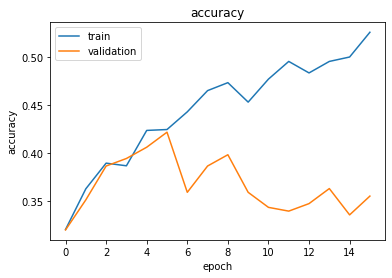

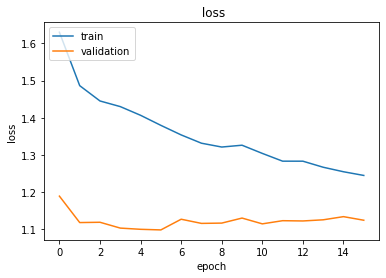

8/8 [==============================] - 12s 760ms/step
[[30 30 20]
 [37 29 34]
 [33 25 18]]
Acuracia balanceada na validacao: 0.3006140350877193


In [ ]:
mo = cria_e_treina_rede(model, lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])